In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scripts import getGiop;
from scripts import getChlor;

In [2]:
wv = np.array((412.,  440.,  490.,  530.,  550.,  670.));
Rrs = np.array([0.007, 0.006, 0.0045, 0.0025, 0.002, 0.0005])
chl = getChlor.getOC(r1=Rrs[1],r2=Rrs[2],r4=Rrs[4],type='oc3m')
print('Chl: %.2f mg m-3'%chl)

Chl: 0.19 mg m-3


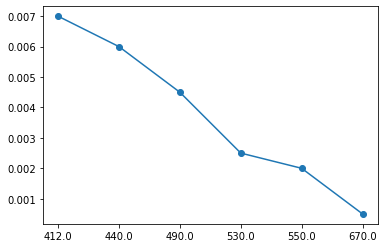

In [3]:
plt.plot(Rrs,marker='o')
plt.xticks(range(len(Rrs)),wv);

In [4]:
#Assume 5% uncertainty in Rrs;
uRrs = Rrs*0.05;
#Generate error-covariance matrix. Assume off-diagonal elements are zero for testing.
covRrs = np.diag(uRrs**2); 


In [5]:
out = getGiop.giop(wv,Rrs,covRrs,chl=chl)
varnames = ['aph','adg','bbp']
for i in range(3):
    print('%s: %.3f +/- %.3f'%
          (varnames[i],out[0][i],np.sqrt(out[1][i,i])))
print('Sdg: %.3f'%out[4])
print('eta: %.3f'%out[5])

aph: 0.321 +/- 0.037
adg: 0.014 +/- 0.001
bbp: 0.002 +/- 0.000
Sdg: 0.016
eta: 1.833


### Test different aph schemes

In [6]:
aph_types = ['bricaud','gsm','ciotti']
print('Method\t aph   adg   bbp   Sdg   eta')
for aph in aph_types:
    out = getGiop.giop(wv,Rrs,covRrs,chl=chl,aph=aph)
    print('%s\t %.3f %.3f %.3f %.3f %.3f'%
          (aph,out[0][0],out[0][1],out[0][2],out[4],out[5]))

Method	 aph   adg   bbp   Sdg   eta
bricaud	 0.321 0.014 0.002 0.016 1.833
gsm	 0.147 0.019 0.001 0.016 1.833
ciotti	 0.367 0.013 0.002 0.016 1.833


### Test different inversion schemes

In [7]:
inv_types = ['lm','lmi','amoeba']
print('Method\t aph   adg   bbp   Sdg   eta')
for inv in inv_types:
    out = getGiop.giop(wv,Rrs,covRrs,chl=chl,inv=inv)
    print('%s\t %.3f %.3f %.3f %.3f %.3f'%
          (inv,out[0][0],out[0][1],out[0][2],out[4],out[5]))

Method	 aph   adg   bbp   Sdg   eta
lm	 0.321 0.014 0.002 0.016 1.833
lmi	 0.513 0.017 0.003 0.016 1.833
amoeba	 0.321 0.014 0.002 0.016 1.833


### Test Bayesian approach (absolute error)

In [8]:
print('Type\taph   adg   bbp   Sdg   eta')
out = getGiop.giop(wv,Rrs,covRrs,chl=chl)
Rrs_3var = out[6]
print('3-var\t%.3f %.3f %.3f %.3f %.3f'%
      (out[0][0],out[0][1],out[0][2],out[4],out[5]))
prior = np.empty(shape=5)
prior[0:3] = out[0]
prior[3] = out[4]
prior[4] = out[5]
cov_prior = np.zeros(shape=(5,5))
cov_prior[0:3][:,0:3] = out[1]
cov_prior[3,3] = 0.002**2
cov_prior[4,4] = 0.025**2
out = getGiop.giop(wv,Rrs,covRrs,chl=chl,num_retr=5,
                   inv='Bayes',prior=prior,cov_prior=cov_prior)
Rrs_bayes = out[6]

print('Bayes\t%.3f %.3f %.3f %.3f %.3f'%
      tuple(out[0]))
out = getGiop.giop(wv,Rrs,covRrs,chl=chl,num_retr=5,badval=np.nan)
print('5-var\t%.3f %.3f %.3f %.3f %.3f'%
      tuple(out[0]))
Rrs_5var = out[6]



Type	aph   adg   bbp   Sdg   eta
3-var	0.321 0.014 0.002 0.016 1.833
Bayes	0.358 0.017 0.002 0.011 1.779
5-var	0.062 0.016 0.001 0.007 -4.104


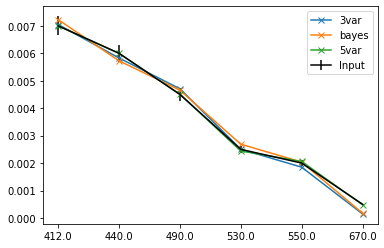

In [9]:
plt.errorbar(range(len(wv)),Rrs,yerr=0.05*Rrs,c='k',label='Input')
plt.plot(Rrs_3var,marker='x',label='3var')
plt.plot(Rrs_bayes,marker='x',label='bayes')
plt.plot(Rrs_5var,marker='x',label='5var')
plt.legend()
plt.xticks(range(len(Rrs)),wv);

### Test Bayesian approach (relative error)

In [10]:
print('Type\taph   adg   bbp   Sdg   eta')
out = getGiop.giop(wv,Rrs,covRrs,chl=chl,error='relative')
Rrs_3var = out[6]
print('3-var\t%.3f %.3f %.3f %.3f %.3f'%
      (out[0][0],out[0][1],out[0][2],out[4],out[5]))
prior = np.empty(shape=5)
prior[0:3] = out[0]
prior[3] = out[4]
prior[4] = out[5]
cov_prior = np.zeros(shape=(5,5))
cov_prior[0:3][:,0:3] = out[1]
cov_prior[3,3] = 0.002**2
cov_prior[4,4] = 0.025**2
out = getGiop.giop(wv,Rrs,covRrs,chl=chl,num_retr=5,error='relative',
                   inv='Bayes',prior=prior,cov_prior=cov_prior)
Rrs_bayes = out[6]

print('Bayes\t%.3f %.3f %.3f %.3f %.3f'%
      tuple(out[0]))
out = getGiop.giop(wv,Rrs,covRrs,chl=chl,num_retr=5,error='relative',badval=np.nan)
print('5-var\t%.3f %.3f %.3f %.3f %.3f'%
      tuple(out[0]))
Rrs_5var = out[6]



Type	aph   adg   bbp   Sdg   eta
3-var	0.469 0.014 0.003 0.016 1.833
Bayes	0.422 0.019 0.003 0.006 1.782
5-var	0.103 0.013 0.001 0.010 -4.750


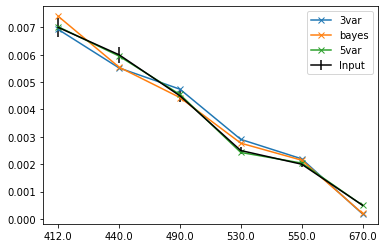

In [11]:
plt.errorbar(range(len(wv)),Rrs,yerr=0.05*Rrs,c='k',label='Input')
plt.plot(Rrs_3var,marker='x',label='3var')
plt.plot(Rrs_bayes,marker='x',label='bayes')
plt.plot(Rrs_5var,marker='x',label='5var')
plt.legend()
plt.xticks(range(len(Rrs)),wv);